In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [6]:
data = pd.read_csv("../experimental_data/wandb_export_2023-05-08T13_46_28.554-04_00.csv")
data = data[data["Name"] != "radiant-wind-116"]  # exploded
data

,Name,trainable_params_M,loss,model_config,use_peft,_wandb
0,graceful-smoke-124,134.105856,3.031250,configs/llama_130m.json,False,NaN
1,generous-darkness-123,71.584512,3.300781,configs/llama_130m.json,True,NaN
2,wobbly-snow-121,58.073600,3.468750,configs/llama_60m.json,False,NaN
3,still-snowball-119,35.197824,3.625000,configs/llama_35m.json,False,NaN
4,fresh-lion-118,30.184320,3.857422,configs/llama_35m.json,True,NaN
5,dainty-glitter-117,9.454720,4.585938,configs/llama_9m.json,True,NaN
7,efficient-thunder-113,42.770944,3.660156,configs/llama_60m.json,True,NaN
8,leafy-glitter-111,18.884864,4.183594,configs/llama_20m.json,True,NaN
9,snowy-vortex-109,19.548416,4.062500,configs/llama_20m.json,False,NaN
10,glowing-leaf-108,8.995968,4.687500,configs/llama_9m.json,False,NaN


Full Models: [ 6.6307701  -0.16239685]
PEFT Models: [ 6.60761947 -0.15910156]


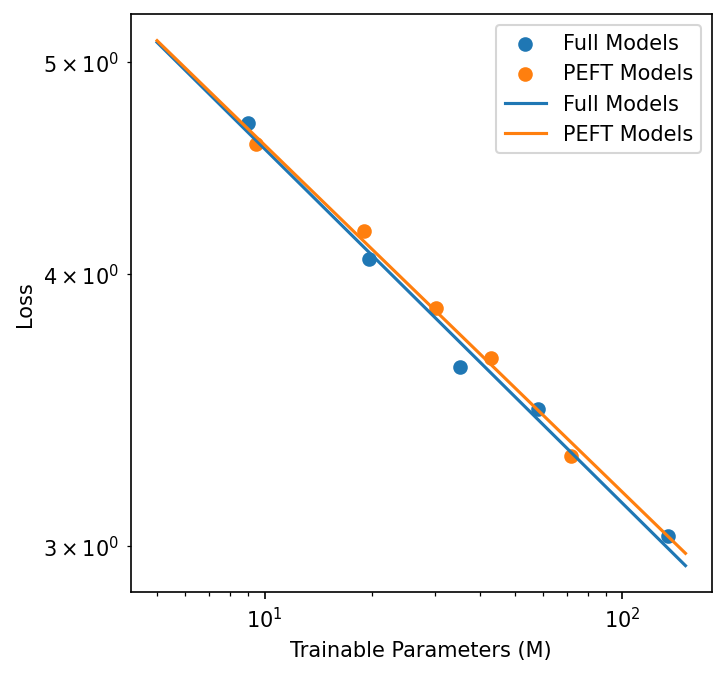

In [27]:
full_models = data[1^data["use_peft"]]
peft_models = data[data["use_peft"]]

full_models_x = full_models["trainable_params_M"]
full_models_y = full_models["loss"]

peft_models_x = peft_models["trainable_params_M"]
peft_models_y = peft_models["loss"]

# figure out the scaling law
# full_models_x = a * full_models_x ** b
# peft_models_x = c * peft_models_x ** d
from scipy.optimize import curve_fit

def func(x, a, b):
    return a * x ** b

full_popt, full_pcov = curve_fit(func, full_models_x, full_models_y)
print(f"Full Models: {full_popt}")

peft_popt, peft_pcov = curve_fit(func, peft_models_x, peft_models_y)
print(f"PEFT Models: {popt}")

plt.figure(figsize=(5, 5), dpi=150)
plt.scatter(full_models_x, full_models_y, label="Full Models")
plt.scatter(peft_models_x, peft_models_y, label="PEFT Models")
plt.xlabel("Trainable Parameters (M)")
plt.ylabel("Loss")
plt.legend()
plt.xscale("log")
plt.yscale("log")

# plot the scaling law
x = np.linspace(5, 150, 100)
plt.plot(x, func(x, *full_popt), label="Full Models")
plt.plot(x, func(x, *peft_popt), label="PEFT Models")
plt.legend()

plt.show()

In [21]:
# perform leave-one-out curve fitting to estimate confidence intervals

full_models_coefficients = []
for i in range(1, len(full_models_x)):
    x = full_models_x.tolist().copy()
    y = full_models_y.tolist().copy()

    x = x[:i] + x[i+1:]
    y = y[:i] + y[i+1:]

    assert len(x) == len(y) == 4
    popt, pcov = curve_fit(func, x, y)
    full_models_coefficients.append(popt)

peft_models_coefficients = []
for i in range(1, len(peft_models_x)):
    x = peft_models_x.tolist().copy()
    y = peft_models_y.tolist().copy()

    x = x[:i] + x[i+1:]
    y = y[:i] + y[i+1:]

    assert len(x) == len(y) == 4
    popt, pcov = curve_fit(func, x, y)
    peft_models_coefficients.append(popt)

full_models_coefficients = np.array(full_models_coefficients)
peft_models_coefficients = np.array(peft_models_coefficients)

full_models_std = np.std(full_models_coefficients, axis=0)
peft_models_stds = np.std(peft_models_coefficients, axis=0)

full_models_mean = np.mean(full_models_coefficients, axis=0)
peft_models_mean = np.mean(peft_models_coefficients, axis=0)

print(f"Full Models: {full_models_mean} +/- {full_models_std}")
print(f"PEFT Models: {peft_models_mean} +/- {peft_models_stds}")

Full Models: [ 6.5563535  -0.15922119] +/- [0.1672472  0.00647486]
PEFT Models: [ 6.70489029 -0.16337305] +/- [0.18046361 0.00694125]
